<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Data-Importing" data-toc-modified-id="Data-Importing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Importing</a></span></li><li><span><a href="#Make-the-train-and-test-dataset" data-toc-modified-id="Make-the-train-and-test-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make the train and test dataset</a></span></li><li><span><a href="#找出缺失的資料" data-toc-modified-id="找出缺失的資料-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>找出缺失的資料</a></span></li><li><span><a href="#視覺化" data-toc-modified-id="視覺化-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>視覺化</a></span></li><li><span><a href="#Feature-Engineering-特徵工程" data-toc-modified-id="Feature-Engineering-特徵工程-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Engineering 特徵工程</a></span></li><li><span><a href="#Feature-Selection-特徵選擇" data-toc-modified-id="Feature-Selection-特徵選擇-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Selection 特徵選擇</a></span></li><li><span><a href="#Modeling-建模型" data-toc-modified-id="Modeling-建模型-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling 建模型</a></span></li></ul></div>

## Import Libraries

In [59]:
#Data Science Import 
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(9,9)

#Avoid warning
import warnings
warnings.filterwarnings('ignore')

#防止中文亂碼問題
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## Data Importing 

In [3]:
order = pd.read_csv('/Users/jacky/Tbrain/dataset/order.csv',
                    parse_dates=['order_date'], dtype={'order_id': np.str, 'group_id': np.str})
group = pd.read_csv('/Users/jacky/Tbrain/dataset/group.csv',
                    parse_dates=['begin_date'], dtype={'group_id': np.str})
airline = pd.read_csv('/Users/jacky/Tbrain/dataset/airline.csv',
                      parse_dates=['fly_time', 'arrive_time'], dtype={'group_id': np.str})
day_schedule = pd.read_csv(
    '/Users/jacky/Tbrain/dataset/day_schedule.csv', dtype={'group_id': np.str})
for dataset in [order, group, airline, day_schedule]:
    print('每個資料集的row數: ', dataset.shape[0])

每個資料集的row數:  396915
每個資料集的row數:  49223
每個資料集的row數:  104275
每個資料集的row數:  307046


In [8]:
train_data = pd.read_csv(
    "/Users/jacky/Tbrain/training-set.csv", dtype={'order_id': np.str})
test_data = pd.read_csv(
    '/Users/jacky/Tbrain/testing-set.csv', dtype={'order_id': np.str})
for data in [train_data, test_data]:
    print('row數: %5s' % (data.shape[0]))

row數: 297020
row數: 99895


## Make the train and test dataset
因為train test資料集在order,group和airline的csv檔中都擺在一起,所以要將其分開

In [9]:
order_train = order.iloc[:train_data.shape[0]]
order_test = order.iloc[train_data.shape[0]:]
group_train = group[group['group_id'].apply(lambda x:len(x) < 7)]
group_test = group[~group['group_id'].apply(lambda x:len(x) < 7)]
airline_train = airline[airline['group_id'].apply(lambda x:len(x) < 7)]
airline_test = airline[~airline['group_id'].apply(lambda x:len(x) < 7)]
day_schedule_train = day_schedule[day_schedule['group_id'].apply(lambda x:len(x) < 7)]
day_schedule_test = day_schedule[~day_schedule['group_id'].apply(lambda x:len(x) < 7)]

In [10]:
order_train_feature = order_train.merge(train_data, on='order_id', how='left')

## 找出缺失的資料 
先透過計算各dataset裡面的column缺的數量

In [11]:
def find_missing(df):
    #計算缺失的數量
    count_missing = df.isnull().sum()
    return pd.DataFrame({'columns': df.columns.values, 'count_missing': count_missing})

#整合並放進list
missing_df = [find_missing(i).reset_index(drop=True) for i in [order_train, order_test, group_train,
                                                      group_test, airline_train, airline_test, day_schedule_train, day_schedule_test]]
#利用pd.concat 將list整合,並根據keys 標出屬於哪個dataset
pd.concat(missing_df, keys=['order_train', 'order_test', 'group_train', 'group_test', 'airline_train',
                   'airline_test', 'day_schedule_train', 'day_schedule_test']).query('count_missing>0')

columns  count_missing
group_train       6    product_name              4
                  7  promotion_prog             31
group_test        6    product_name              1
                  7  promotion_prog             25
day_schedule_test 2           title             11

## 視覺化

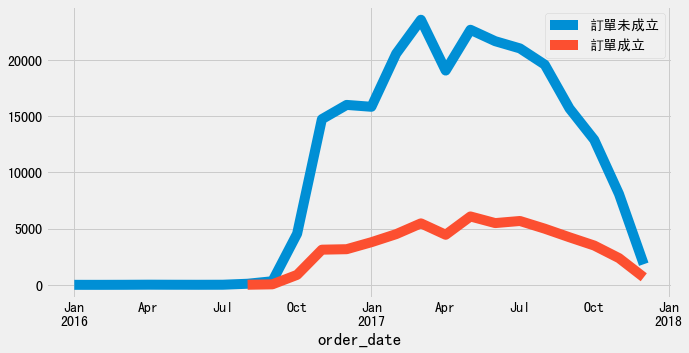

In [60]:
# A Grouper allows the user to specify a groupby instruction for a target object
plt.figure(figsize=(10,5))
for order_status in [0, 1]:
    order_train_feature[order_train_feature['deal_or_not'] == order_status].set_index(
        'order_date').groupby(pd.Grouper(freq='M'))['deal_or_not'].count().plot(linewidth=10)
plt.legend(labels=['訂單未成立', '訂單成立'])
plt.show()

訂單未成立    238432
訂單成立      58588
Name: deal_or_not, dtype: int64


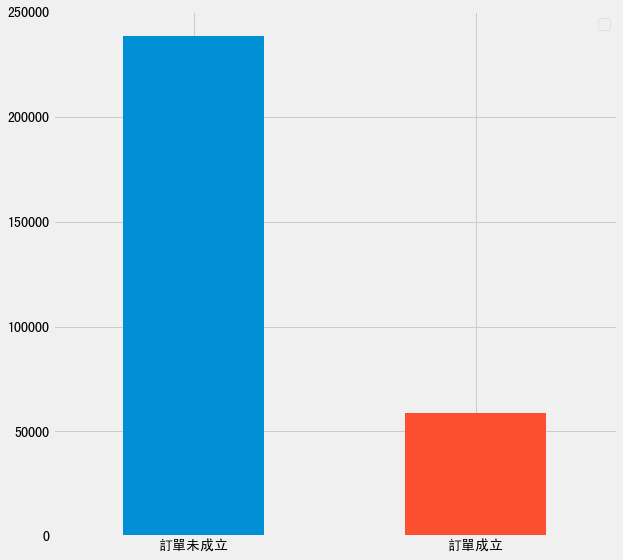

In [61]:
# 將資料分成訂單成立or不成立
df_cat=train_data['deal_or_not'].value_counts()
df_cat.plot.bar()
plt.xticks([0, 1], ['訂單未成立', '訂單成立'], rotation=0)
plt.legend('')
print(df_cat.rename(index={0:'訂單未成立',1:'訂單成立'}))
plt.show()

In [40]:
#依據訂單成立和不成立來區隔feature
def plot_feature(df, column, target, aggfunc, xlabel):
    plt.style.use('fivethirtyeight')
    df.pivot_table(index=column, columns=target, aggfunc=aggfunc).apply(
        lambda x: x/x.sum(),axis=1).plot.bar()
    plt.xticks(range(df[column].nunique()), df[column].unique(), rotation=0)
    plt.xlabel('%s' % xlabel)
    plt.legend(labels=['訂單未成立', '訂單成立'])
    plt.title(f'訂單 vs {column}')
    plt.show()

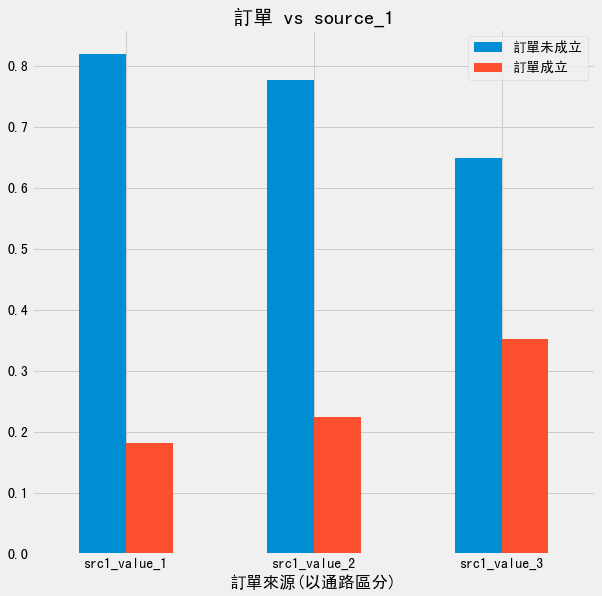

In [62]:
plot_feature(order_train_feature,'source_1','deal_or_not','size','訂單來源(以通路區分)')

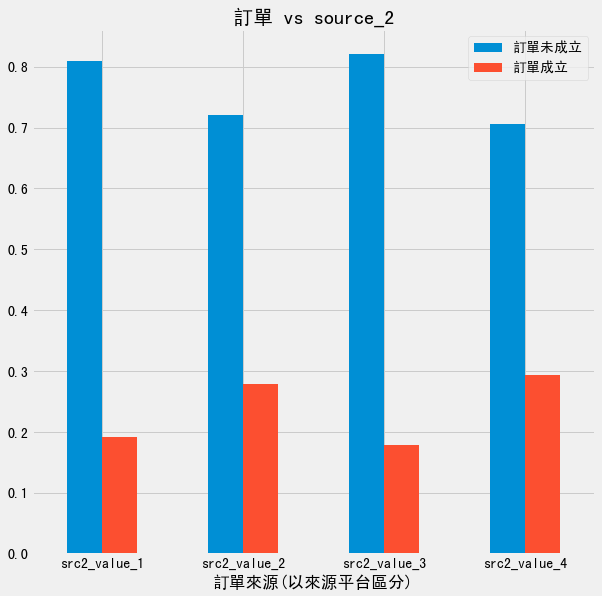

In [63]:
plot_feature(order_train_feature,'source_2','deal_or_not','size','訂單來源(以來源平台區分)')

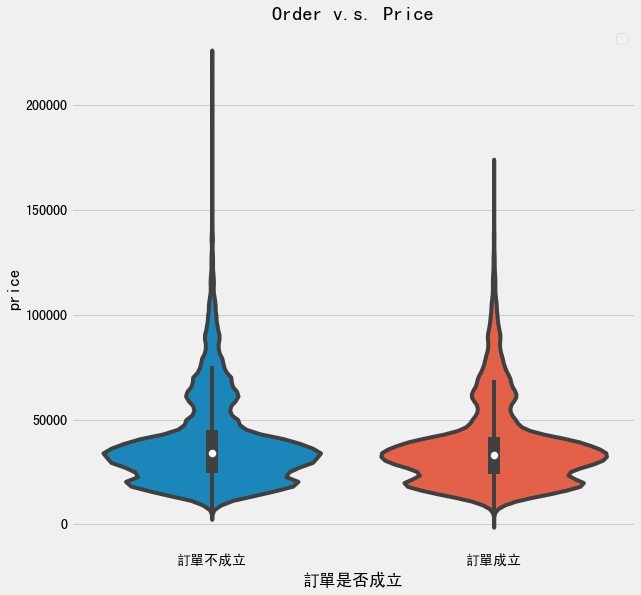

In [64]:
order_group_train = order_train.merge(group_train, on='group_id', how='left')
price_order = pd.concat([order_group_train['price'], train_data['deal_or_not']], axis=1)
sns.violinplot(x='deal_or_not', y='price', data=price_order)
plt.title('Order v.s. Price')
plt.xlabel('訂單是否成立');plt.xticks([0, 1], ['訂單不成立', '訂單成立']);plt.legend('')
plt.show()

In [65]:
order_group_train=order_train.merge(group_train,on='group_id',how='left')
order_group_test=order_test.merge(group_test,on='group_id',how='left')
order_group_target_train=order_group_train.merge(train_data,on='order_id',how='left')
order_group_target_test=order_group_test.merge(test_data,on='order_id',how='left')

<Figure size 1080x720 with 0 Axes>

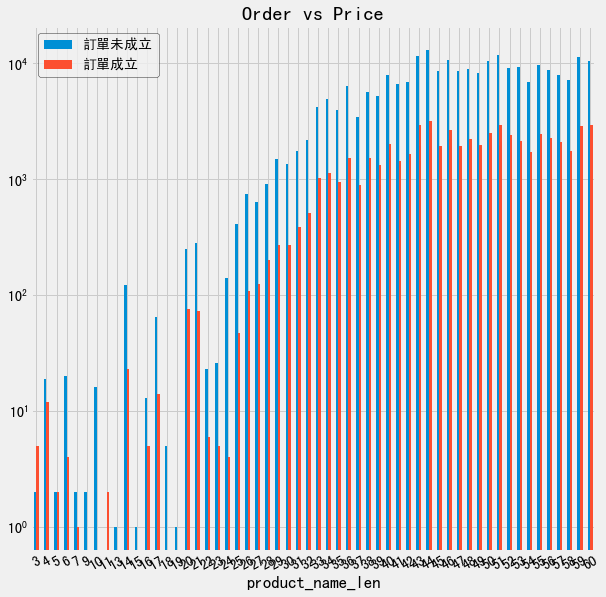

In [73]:
plt.figure(figsize=(15,10))
order_group_target_train['product_name_len'] = order_group_target_train['product_name'].apply(
    lambda x: len(str(x).strip()))
order_group_target_train.groupby('product_name_len')[
    'deal_or_not'].value_counts().unstack().plot.bar(logy=True)
plt.xticks(rotation=30);plt.title('Order vs Price')
plt.legend(labels=['訂單未成立','訂單成立'],frameon=True,edgecolor='black')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

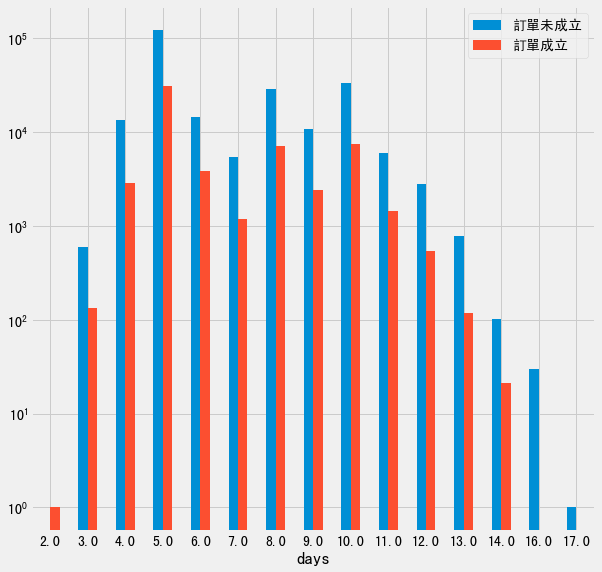

In [74]:
order_group_target_train.groupby(['days'])['deal_or_not'].value_counts().unstack().plot.bar(logy=True)
plt.legend(labels=['訂單未成立','訂單成立'])
plt.xticks(rotation=0)

## Feature Engineering 特徵工程

In [76]:
print(order_train['group_id'].unique().shape)
print(airline_train['group_id'].unique().shape)

(35292,)
(34952,)


In [77]:
print(order_test['group_id'].unique().shape)
print(airline_test['group_id'].unique().shape)

(9750,)
(13844,)


In [83]:
def go_or_not_train(order, airline):
    k = list(order['group_id'].unique())
    for i in list(airline['group_id'].unique()):
        try:
            k.remove(i)
        except:
            k
    unique_id = list(airline.group_id.unique())
    go_or_not = pd.DataFrame(
        {'group_id': unique_id+k, 'go_or_not': [1]*len(unique_id)+[0]*len(k)})
    return go_or_not


def go_or_not_test(order, airline):
    k = list(order['group_id'].unique())
    weird = []
    for i in list(airline['group_id'].unique()):
        try:
            k.remove(i)
        except:
            weird.append(i)
    unique_id = [i for i in list(airline.group_id.unique()) if i not in weird]
    go_or_not = pd.DataFrame(
        {'group_id': unique_id+k, 'go_or_not': [1]*len(unique_id)+[0]*len(k)})
    return go_or_not

In [84]:
go_or_not_train = go_or_not_train(order_train, airline_train)
go_or_not_test = go_or_not_test(order_test, airline_test)
order_go_train_features = order_train.merge(
    go_or_not_train, on='group_id', how='left')
order_go_test_features = order_test.merge(
    go_or_not_test, on='group_id', how='left')
print(order_go_train_features.shape)
print(order_go_test_features.shape)

(297020, 8)
(99895, 8)


In [1246]:
def change(x):
    if x in [1, 2, 7, 8, 9, 12]:
        x = '旺季'
    else:
        x = '淡季'
    return x
# order_group_train['high_low_season']=order_group_train.begin_date.dt.month.apply(change)
# order_group_test['high_low_season']=order_group_test.begin_date.dt.month.apply(change)

In [1843]:
def date_difference(df):
    df['date_difference'] = df.eval(
        'begin_date-order_date').astype('str').apply(lambda x: x.split()[0])
    df['date_difference'] = df['date_difference'].astype(np.int)
    return df


def price_dats_ratio(df):
    df['price_dats_ratio'] = df.eval('price/people_amount')
    return df


def day_change(x):
    if x in [0, 1, 2, 3, 4]:
        x = 'other'
    elif x == 5:
        x = 'saturday'
    else:
        x = 'sunday'
    return x


def airline_transfer(df, go_back):
    k = df[df['go_back'] == go_back]['group_id']
    df = df.iloc[k[k.duplicated(False)].index, :]
    return list(df.group_id.unique())


def airline_transfer_test(df, go_back):
    k5 = list(order_group_test['group_id'].unique())
    weird = []
    for i in list(airline_test['group_id'].unique()):
        try:
            k5.remove(i)
        except:
            weird.append(i)
    unique_id = [i for i in list(
        airline_test.group_id.unique()) if i not in weird]
    go_or_back = airline_test[airline_test['go_back']
                              == go_back]['group_id'].duplicated(False)
    unique_group = airline_test.loc[go_or_back.index, :].group_id.unique()
    index = [i for i in unique_group if i not in weird]
    return index

In [1719]:
def airport_name(df):
    df = df[df['go_back'] == '去程'].drop_duplicates(subset=['group_id']).\
        set_index('group_id').dst_airport.str.split().apply(
            lambda x: x[1][:-2])
    return df


airport_name_train = airport_name(airline_train)
airport_name_train = airport_name_train.replace({'洛杉機': '洛杉磯'})
airport_name_test = airport_name(airline_test)

In [1854]:
def route(df):
    k = df[df['go_back'] == '去程'].set_index(
        'group_id')[['src_airport', 'dst_airport']].applymap(lambda x: x.split()[1][:-2])
    k['new'] = k['src_airport']+'-'+k['dst_airport']
    b = []
    for num, i in enumerate(k.index):
        if k.index.duplicated(False)[num]:
            a = ''.join(k.loc[i, 'new'].values)
            b.append(a)
        else:
            b.append(k.loc[i, 'new'])
    k['route'] = b
    return k


def route_train_unique(order, airline):
    k = list(order['group_id'].unique())
    for i in list(airline['group_id'].unique()):
        try:
            k.remove(i)
        except:
            print(i)
    return k


def route_test_unique(order, airline):
    k = list(order['group_id'].unique())
    weird = []
    for i in list(airline['group_id'].unique()):
        try:
            k.remove(i)
        except:
            weird.append(i)
    unique_id = [i for i in list(
        airline_test.group_id.unique()) if i not in weird]
    return unique_id

In [2604]:
airline_train['fly_time_hour']=airline_train.fly_time.dt.hour

In [2605]:
order_group_train.merge(airline_train[airline_train['go_back'] == '去程'][[
                        'group_id', 'fly_time_hour']].drop_duplicates(subset='group_id'), on='group_id', how='left').shape

(297020, 15)

In [2606]:
airline_test['fly_time_hour']=airline_test.fly_time.dt.hour
order_group_test.merge(airline_test[airline_test['go_back']=='去程'][['group_id','fly_time_hour']].drop_duplicates(subset='group_id'),on='group_id',how='left').shape

(99895, 15)

In [1890]:
route_train=route(airline_train)
route_test=route(airline_test)

In [1891]:
route_train=route_train.reset_index().drop_duplicates(subset='group_id')
route_test=route_test.reset_index().drop_duplicates(subset='group_id')
train_id_route=route_train_unique(order_train,route_train.reset_index())
test_id_route=route_test_unique(order_test,route_test.reset_index())

In [1763]:
from datetime import datetime,timedelta

In [2455]:
k, a = airline_transfer(airline_train, '去程')
train_transfer_df = pd.DataFrame(
    {'group_id': k, 'transfer_back': np.ones(len(k))})
order_group_train = order_group_train.merge(
    train_transfer_df, on='group_id', how='left').fillna(0)
index = airline_transfer_test(airline_train, '去程')
test_transfer_df = pd.DataFrame(
    {'group_id': index, 'transfer_back': np.ones(len(index))})
order_group_test = order_group_test.merge(
    test_transfer_df, on='group_id', how='left').fillna(0)

In [2607]:
airline_train['fly_time_hour']=airline_train.fly_time.dt.hour
airline_test['fly_time_hour']=airline_test.fly_time.dt.hour
airline_train['arrive_time_hour']=airline_train.arrive_time.dt.hour
airline_test['arrive_time_hour']=airline_test.arrive_time.dt.hour

In [2609]:
# order_group_train['high_low_season']=order_group_train.begin_date.dt.month.apply(change)
order_group_train = order_group_train.merge(
    pd.DataFrame(airport_name_train), how='left', on='group_id')
order_group_train = date_difference(order_group_train)
order_group_train = order_group_train.merge(
    route_train[['group_id', 'route']], on='group_id', how='left').fillna('other')
order_group_train = order_group_train.merge(airline_train[airline_train['go_back'] == '去程'][['group_id', 'fly_time_hour']].
                                            drop_duplicates(subset='group_id'), on='group_id', how='left')
order_group_train = order_group_train.merge(airline_train[airline_train['go_back'] == '回程'][['group_id', 'arrive_time_hour']].
                                            drop_duplicates(subset='group_id'), on='group_id', how='left')
group_expectation_train = order_group_target_train.groupby(
    'group_id')['deal_or_not'].count().apply(lambda x: x*0.197253).reset_index()
order_group_train = order_group_train.merge(
    group_expectation_train, on='group_id', how='left')
people_expectation_train = order_group_target_train.groupby(['group_id'])['people_amount'].sum().apply(
    lambda x: 0 if x <= 5 else 1).reset_index().rename(columns={'people_amount': 'people_expectation'})
order_group_train = order_group_train.merge(
    people_expectation_train, on='group_id', how='left')
order_group_train = order_group_train.replace({'桃園-洛杉機': '桃園-洛杉磯'})
order_group_train['date_month'] = order_group_train['begin_date'].dt.month
order_group_train['day_of_week_begin'] = order_group_train['begin_date'].dt.dayofweek
order_group_train['day_of_week_order'] = order_group_train['order_date'].dt.dayofweek
order_group_train['month_difference'] = abs(
    order_group_train['begin_date'].dt.month-order_group_train['order_date'].dt.month)
order_group_train['day_of_week_end'] = (
    order_group_train['begin_date']+order_group_train['days'].apply(lambda x: timedelta(int(x)))).dt.dayofweek
# order_group_train=order_group_train.eval('price_people_days=price*people_amount/days')
# order_group_train=price_dats_ratio(order_group_train)
features_data_train = order_group_train[['order_id', 'group_id', 'source_1', 'source_2', 'unit', 'people_amount',
                                         'sub_line', 'area', 'days', 'price', 'date_difference', 'date_month',
                                         'day_of_week_begin', 'day_of_week_end', 'dst_airport', 'day_of_week_order',
                                         'route', 'deal_or_not', 'fly_time_hour', 'arrive_time_hour']]
order_group_test = date_difference(order_group_test)
# order_group_test['high_low_season']=order_group_test.begin_date.dt.month.apply(change)
# order_group_test=price_dats_ratio(order_group_test)
order_group_test = order_group_test.merge(
    pd.DataFrame(airport_name_test), how='left', on='group_id')
order_group_test = order_group_test.merge(
    route_test[['group_id', 'route']], on='group_id', how='left').fillna('other')
group_expectation_test = order_group_test.groupby('group_id')['month_difference'].count().apply(
    lambda x: x*0.197253).reset_index().rename(columns={'month_difference': 'deal_or_not'})
order_group_test = order_group_test.merge(
    group_expectation_test, on='group_id', how='left')
people_expectation_test = order_group_target_test.groupby(['group_id'])['people_amount'].sum().apply(
    lambda x: 0 if x <= 5 else 1).reset_index().rename(columns={'people_amount': 'people_expectation'})
order_group_test = order_group_test.merge(
    people_expectation_test, on='group_id', how='left')
order_group_test = order_group_test.merge(airline_test[airline_test['go_back'] == '去程'][['group_id', 'fly_time_hour']].
                                          drop_duplicates(subset='group_id'), on='group_id', how='left')
order_group_test = order_group_test.merge(airline_test[airline_test['go_back'] == '回程'][['group_id', 'arrive_time_hour']].
                                          drop_duplicates(subset='group_id'), on='group_id', how='left')
order_group_test['day_of_week_begin'] = order_group_test['begin_date'].dt.dayofweek
order_group_test['day_of_week_order'] = order_group_test['order_date'].dt.dayofweek
order_group_test['day_of_week_end'] = (
    order_group_test['begin_date']+order_group_test['days'].apply(lambda x: timedelta(int(x)))).dt.dayofweek
order_group_test['date_month'] = order_group_test['begin_date'].dt.month
order_group_test['month_difference'] = abs(
    order_group_test['begin_date'].dt.month-order_group_test['order_date'].dt.month)
# order_group_test=order_group_test.eval('price_people_days=price*people_amount/days')
features_data_test = order_group_test[['order_id', 'group_id', 'source_1', 'source_2', 'unit', 'people_amount',
                                       'sub_line', 'area', 'days', 'price', 'date_difference', 'date_month',
                                       'day_of_week_begin', 'day_of_week_end', 'dst_airport', 'day_of_week_order',
                                       'route', 'deal_or_not', 'fly_time_hour', 'arrive_time_hour']]

In [1589]:
k4=airline_test[airline_test['go_back']=='回程']['group_id'].duplicated(False)
unique_group=airline_test.loc[k4.index,:].group_id.unique()

In [2610]:
features_data_train['price_total']=features_data_train['people_amount'].mul(features_data_train['price'])
features_data_test['price_total']=features_data_test['people_amount'].mul(features_data_test['price'])
#features_data_train['go_or_not']=order_go_train_features['go_or_not']
#features_data_test['go_or_not']=order_go_test_features['go_or_not']

In [2611]:
def clearRare(columnname,limit=500):
    value=features_data_test[columnname].value_counts()
    #將出現超過500次的設定為True
    common=value>limit
    #取出為True的column name
    common=set(common.index[common].values)
    print('Set', sum(value<=limit),columnname,"categories to 'other';",end=" ")
    
    #將common的全部調整為'other'
    #map裡面是指x 如果不在common裡 就會是True
    features_data_train.loc[features_data_train[columnname].map(lambda x:x not in common),columnname]='other'
    features_data_test.loc[features_data_test[columnname].map(lambda x:x not in common),columnname]='other'
    print('now there are', features_data_train[columnname].nunique(),'categories in train')

In [2612]:
clearRare('source_1')
clearRare('unit')
clearRare('sub_line')
clearRare('area')
clearRare('dst_airport',200)
clearRare('route',100)

Set 0 source_1 categories to 'other'; now there are 3 categories in train
Set 65 unit categories to 'other'; now there are 60 categories in train
Set 5 sub_line categories to 'other'; now there are 19 categories in train
Set 90 area categories to 'other'; now there are 45 categories in train
Set 39 dst_airport categories to 'other'; now there are 75 categories in train
Set 123 route categories to 'other'; now there are 129 categories in train


In [2613]:
from sklearn.preprocessing import Imputer

In [2614]:
imputer=Imputer(missing_values='NaN',strategy='most_frequent')
imputer.fit(features_data_train['fly_time_hour'].values.reshape(-1,1))
features_data_train['fly_time_hour']=imputer.transform(features_data_train['fly_time_hour'].values.reshape(-1,1))
features_data_test['fly_time_hour']=imputer.transform(features_data_test['fly_time_hour'].values.reshape(-1,1))

imputer=Imputer(missing_values='NaN',strategy='most_frequent')
imputer.fit(features_data_train['arrive_time_hour'].values.reshape(-1,1))
features_data_train['arrive_time_hour']=imputer.transform(features_data_train['arrive_time_hour'].values.reshape(-1,1))
features_data_test['arrive_time_hour']=imputer.transform(features_data_test['arrive_time_hour'].values.reshape(-1,1))

In [2360]:
from sklearn.preprocessing import LabelEncoder

In [2535]:
features_data_test=features_data_test.replace({'桃園-首爾仁川首爾仁川-伊斯坦堡阿塔圖克':'other','桃園-香港香港-布魯塞爾':'other',
                                              '高雄-名古屋中部':'other'})

In [2536]:
label=LabelEncoder()
object_train=features_data_train.select_dtypes('object').drop(columns=['order_id','group_id'])
for i in object_train.columns:
    features_data_train.loc[:,i]=label.fit_transform(features_data_train.loc[:,i])
    features_data_test.loc[:,i]=label.transform(features_data_test.loc[:,i])

In [2537]:
train_features=features_data_train.drop(columns=['order_id','group_id'])
test_features=features_data_test.drop(columns=['order_id','group_id'])

In [2615]:
train_features=pd.get_dummies(features_data_train.drop(columns=['order_id','group_id']),drop_first=True)
train_features.shape

(297020, 340)

In [2616]:
test_features=pd.get_dummies(features_data_test.drop(columns=['order_id','group_id']),drop_first=True)
test_features.shape

(99895, 343)

In [2617]:
test_features=test_features.drop(columns=['route_桃園-首爾仁川首爾仁川-伊斯坦堡阿塔圖克', 'route_桃園-香港香港-布魯塞爾', 'route_高雄-名古屋中部'])
test_features.shape

(99895, 340)

In [2618]:
print([i for i in test_features.columns if i not in train_features.columns])

[]


In [2619]:
print(all(train_features.columns==test_features.columns))

True


## Feature Selection 特徵選擇 

In [88]:
from feature_selector import FeatureSelector

In [2470]:
fs.identify_collinear(correlation_threshold=0.9)

69 features with a correlation magnitude greater than 0.90.



In [2469]:
fs = FeatureSelector(train_features, train_data['deal_or_not'])
fs.identify_zero_importance(task='classification',
                            eval_metric='auc', #用auc來衡量
                            n_iterations=10,
                            early_stopping=True)
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['people_amount', 'days', 'price', 'date_difference', 'date_month', 'day_of_week_begin', 'day_of_week_end', 'day_of_week_order', 'deal_or_not', 'fly_time_hour', 'arrive_time_hour', 'price_total', 'source_1_src1_value_2', 'source_1_src1_value_3', 'source_2_src2_value_2', 'source_2_src2_value_3', 'source_2_src2_value_4', 'unit_unit_value_1', 'unit_unit_value_10', 'unit_unit_value_100', 'unit_unit_value_104', 'unit_unit_value_11', 'unit_unit_value_12', 'unit_unit_value_13', 'unit_unit_value_14', 'unit_unit_value_15', 'unit_unit_value_16', 'unit_unit_value_17', 'unit_unit_value_18', 'unit_unit_value_19', 'unit_unit_value_2', 'unit_unit_value_20', 'unit_unit_value_21', 'unit_unit_value_22', 'unit_unit_value_23', 'unit_unit_value_27', 'unit_unit_value_29', 'unit_unit_value_3', 'unit_unit_value_30', 'unit_unit_value_31', 'unit_unit_value_33', 'unit_unit_value_36', 'unit_unit_value_37', 'unit_unit_value_39', 'unit_unit_value_40', 'unit_unit_value_41', 'unit_unit_value_42', 'unit_unit_value_44'

['route_桃園-紐約甘乃迪',
 'route_桃園-黃山屯溪',
 'route_桃園-麗江三義',
 'route_桃園-富山',
 'route_桃園-峇里島',
 'route_桃園-小松',
 'route_台北松山-首爾金浦',
 'route_台北松山-溫州龍灣國際',
 'route_台北松山-東京羽田',
 'dst_airport_南京祿口',
 'route_高雄-熊本',
 'route_桃園-巴黎戴高樂',
 'route_桃園-張家界',
 'route_桃園-鹿兒島',
 'route_桃園-太原武宿',
 'route_桃園-宿霧',
 'route_桃園-桂林兩江',
 'route_桃園-羅馬達文西',
 'route_桃園-呼和浩特白塔',
 'route_桃園-貴陽龍洞堡',
 'route_桃園-瀋陽桃仙',
 'route_桃園-吉隆坡',
 'route_桃園-金邊',
 'route_桃園-銀川河東',
 'route_桃園-墨爾本',
 'route_桃園-阿姆斯特丹',
 'route_桃園-濟南遙牆',
 'route_桃園-青島流亭',
 'area_area_value_90',
 'route_桃園-大邱',
 'route_桃園-函館',
 'route_桃園-溫哥華',
 'route_桃園-洛杉磯',
 'route_桃園-倫敦蓋威克',
 'route_桃園-法蘭克福',
 'area_area_value_96',
 'route_桃園-維也納',
 'route_桃園-宮崎',
 'route_桃園-雪梨']

In [2471]:
fs.identify_low_importance(cumulative_importance=0.99)

205 features required for cumulative importance of 0.99 after one hot encoding.
135 features do not contribute to cumulative importance of 0.99.



In [2472]:
fs.record_low_importance.head()

,feature,importance,normalized_importance,cumulative_importance
205,dst_airport_溫哥華,6.0,0.000235,0.990105
206,sub_line_subline_value_19,5.9,0.000231,0.990336
207,route_桃園-伊斯坦堡阿塔圖克伊斯坦堡阿塔圖克-馬拉加,5.8,0.000227,0.990563
208,unit_unit_value_90,5.7,0.000223,0.990786
209,dst_airport_曼谷蘇凡納布,5.7,0.000223,0.991009


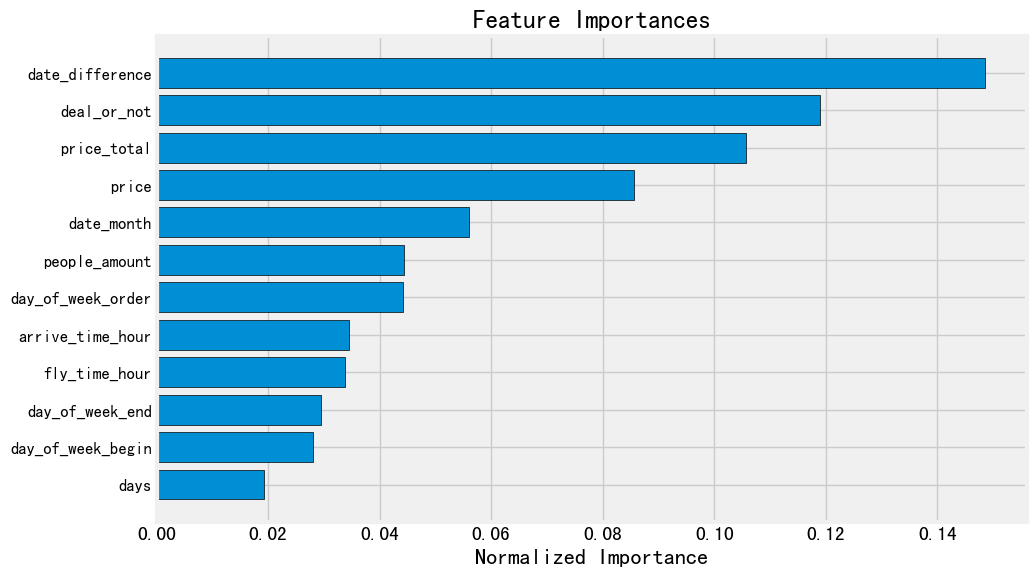

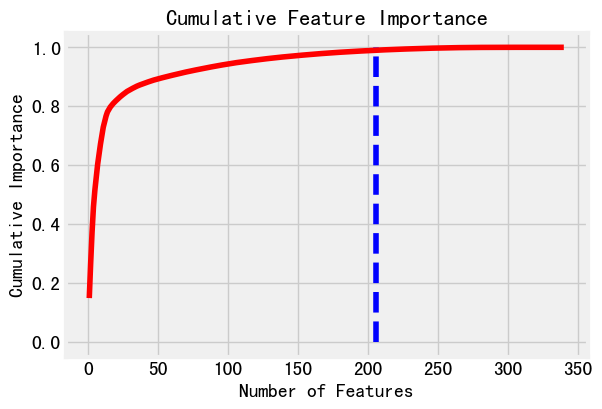

206 features required for 0.99 of cumulative importance


In [2473]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [2474]:
train_removed=fs.remove(methods='all')

['zero_importance', 'low_importance', 'collinear'] methods have been run

Removed 149 features.


In [2475]:
train_removed.shape

(297020, 191)

In [2408]:
features_data_train.head()

,order_id,group_id,source_1,source_2,unit,people_amount,sub_line,area,days,price,date_difference,date_month,day_of_week_begin,day_of_week_end,dst_airport,day_of_week_order,route,deal_or_not,fly_time_hour,price_total
0,136100,63695,0,0,1,2,1,44,12.0,106900.0,76,3,2,0,0,3,0,0.591759,23.0,213800.0
1,140370,63695,0,0,14,1,1,44,12.0,106900.0,133,3,2,0,0,2,0,0.591759,23.0,106900.0
2,211009,63695,0,0,21,2,1,44,12.0,106900.0,61,3,2,0,0,4,0,0.591759,23.0,213800.0
3,41571,53481,0,0,0,4,1,44,12.0,112900.0,64,5,2,0,0,1,0,0.789012,23.0,451600.0
4,64125,53481,1,0,0,1,1,44,12.0,112900.0,51,5,2,0,0,0,0,0.789012,23.0,112900.0


## Modeling 建模型 

In [2640]:
from sklearn.metrics import (roc_auc_score,precision_score,recall_score,f1_score)
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_removed,train_data['deal_or_not'],test_size=0.2,stratify=train_data['deal_or_not'])

In [2634]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.

       Returns the model and the predictions."""

    model.fit(train, y)

    # Predict probabilities and labels
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    # Calculate ROC AUC
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0] #將原本模型函數轉換成string來表示
    print("%s" %name)
    print('ROC AUC: {}'.format(round(roc, 4)))

    # Iterate through metrics
    for metric in [precision_score, recall_score, f1_score]:
        # Use .__name__ attribute to list metric 轉換成string放入
        print('{}: {}'.format(metric.__name__,round(metric(test_y, preds), 4)))

    return model, preds


model, preds = evaluate(pipe, x_train, y_train, x_test, y_test)

/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Pipeline
ROC AUC: 0.6218
precision_score: 0.6546
recall_score: 0.0632
f1_score: 0.1153


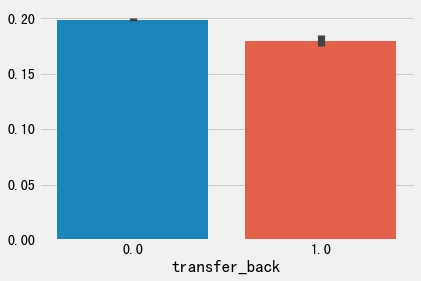

In [1145]:
sns.barplot(x=order_group_train['transfer_back'],y=train_data.deal_or_not.values)

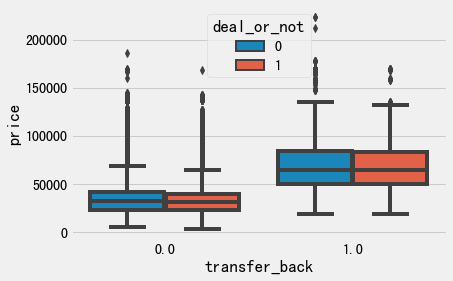

In [1006]:
sns.boxplot(x='transfer_back',y='price',hue=train_data.deal_or_not,data=order_group_train)

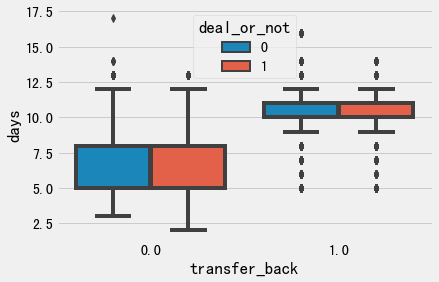

In [1007]:
sns.boxplot(x='transfer_back',y='days',hue=train_data.deal_or_not,data=order_group_train)

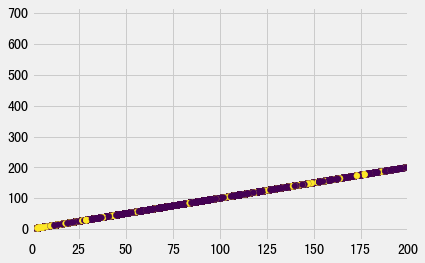

In [1014]:
plt.scatter(order_group_train['date_difference'],order_group_train['date_difference'],c=train_data.deal_or_not)
plt.xlim([0,200])
plt.show()

In [1106]:
k={i:j for i,j in zip(airport_code['Airport Code'],airport_code['Country name'])}

In [2641]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf=50,
                               n_jobs=-1, class_weight='balanced')

model, preds = evaluate(model, x_train, y_train, x_test, y_test)

RandomForestClassifier
ROC AUC: 0.7209
precision_score: 0.31
recall_score: 0.648
f1_score: 0.4194


In [2642]:
feature_importance=pd.DataFrame({'importance':model.feature_importances_},index=x_train.columns).sort_values(by='importance',ascending=False).reset_index()
feature_importance

,index,importance
0,deal_or_not,3.007763e-01
1,date_difference,1.104682e-01
2,people_amount,7.151542e-02
3,unit_unit_value_100,5.834490e-02
4,price_total,5.176552e-02
5,source_1_src1_value_2,4.760558e-02
6,source_2_src2_value_4,3.660579e-02
7,price,3.278280e-02
8,source_1_src1_value_3,2.893591e-02
9,unit_unit_value_104,1.958121e-02


In [2631]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe=Pipeline([['sc',StandardScaler()],
              ['lda',LinearDiscriminantAnalysis()],
              ['model',LogisticRegression()]])
pipe.fit(x_train,y_train)


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ['model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)]])

In [2620]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

params={'reg_lambda': 0.43702345115978314, 
        'boosting_type': 'dart', 
        'num_leaves': 44, 
        'learning_rate': 0.08783831758750019,
        'colsample_bytree': 0.6077910448089742, 
        'min_child_samples': 230, 
        'subsample_for_bin': 120000, 
        'verbose': 1, 
        'class_weight':
        'balanced', 
        'metric': 'auc', 
        'reg_alpha': 0.16571225625681618, 
        'subsample': 0.9699110051642057}

folds=KFold(n_splits=5)

n_fold = 5

model = lgb.LGBMClassifier(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)

oof_reg_preds = np.zeros(train_removed.shape[0])
prediction = np.zeros(test_features[train_removed.columns].shape[0])

for fold_n, (trn_, val_) in enumerate(folds.split(train_removed,train_data.deal_or_not)):
    print('Fold:', fold_n)
    trn_x, trn_y = train_removed.iloc[trn_], train_data.iloc[trn_,1]
    val_x, val_y = train_removed.iloc[val_], train_data.iloc[val_,1]
    

    model.fit(trn_x, trn_y, 
            eval_set=[(trn_x, trn_y), (val_x, val_y)], eval_metric='auc',
            verbose=500, early_stopping_rounds=200)
    
    oof_reg_preds[val_] = model.predict(val_x, num_iteration=model.best_iteration_)
    
    pred = model.predict_proba(test_features[train_removed.columns], num_iteration=model.best_iteration_)[:,1]
    prediction += pred
    
prediction /= n_fold

Fold: 0
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.760447	valid_1's auc: 0.715724
Early stopping, best iteration is:
[611]	training's auc: 0.765101	valid_1's auc: 0.716419


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold: 1
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.763065	valid_1's auc: 0.706223
Early stopping, best iteration is:
[681]	training's auc: 0.769782	valid_1's auc: 0.706668


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold: 2
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.760044	valid_1's auc: 0.723395
Early stopping, best iteration is:
[481]	training's auc: 0.758504	valid_1's auc: 0.72363


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold: 3
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.762019	valid_1's auc: 0.722146
Early stopping, best iteration is:
[713]	training's auc: 0.771136	valid_1's auc: 0.722628


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold: 4
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.760428	valid_1's auc: 0.708474
Early stopping, best iteration is:
[548]	training's auc: 0.762646	valid_1's auc: 0.709057


/Users/jacky/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [2623]:
prediction

array([0.0546564 , 0.31593738, 0.89084064, ..., 0.02399019, 0.0238143 ,
       0.05573439])

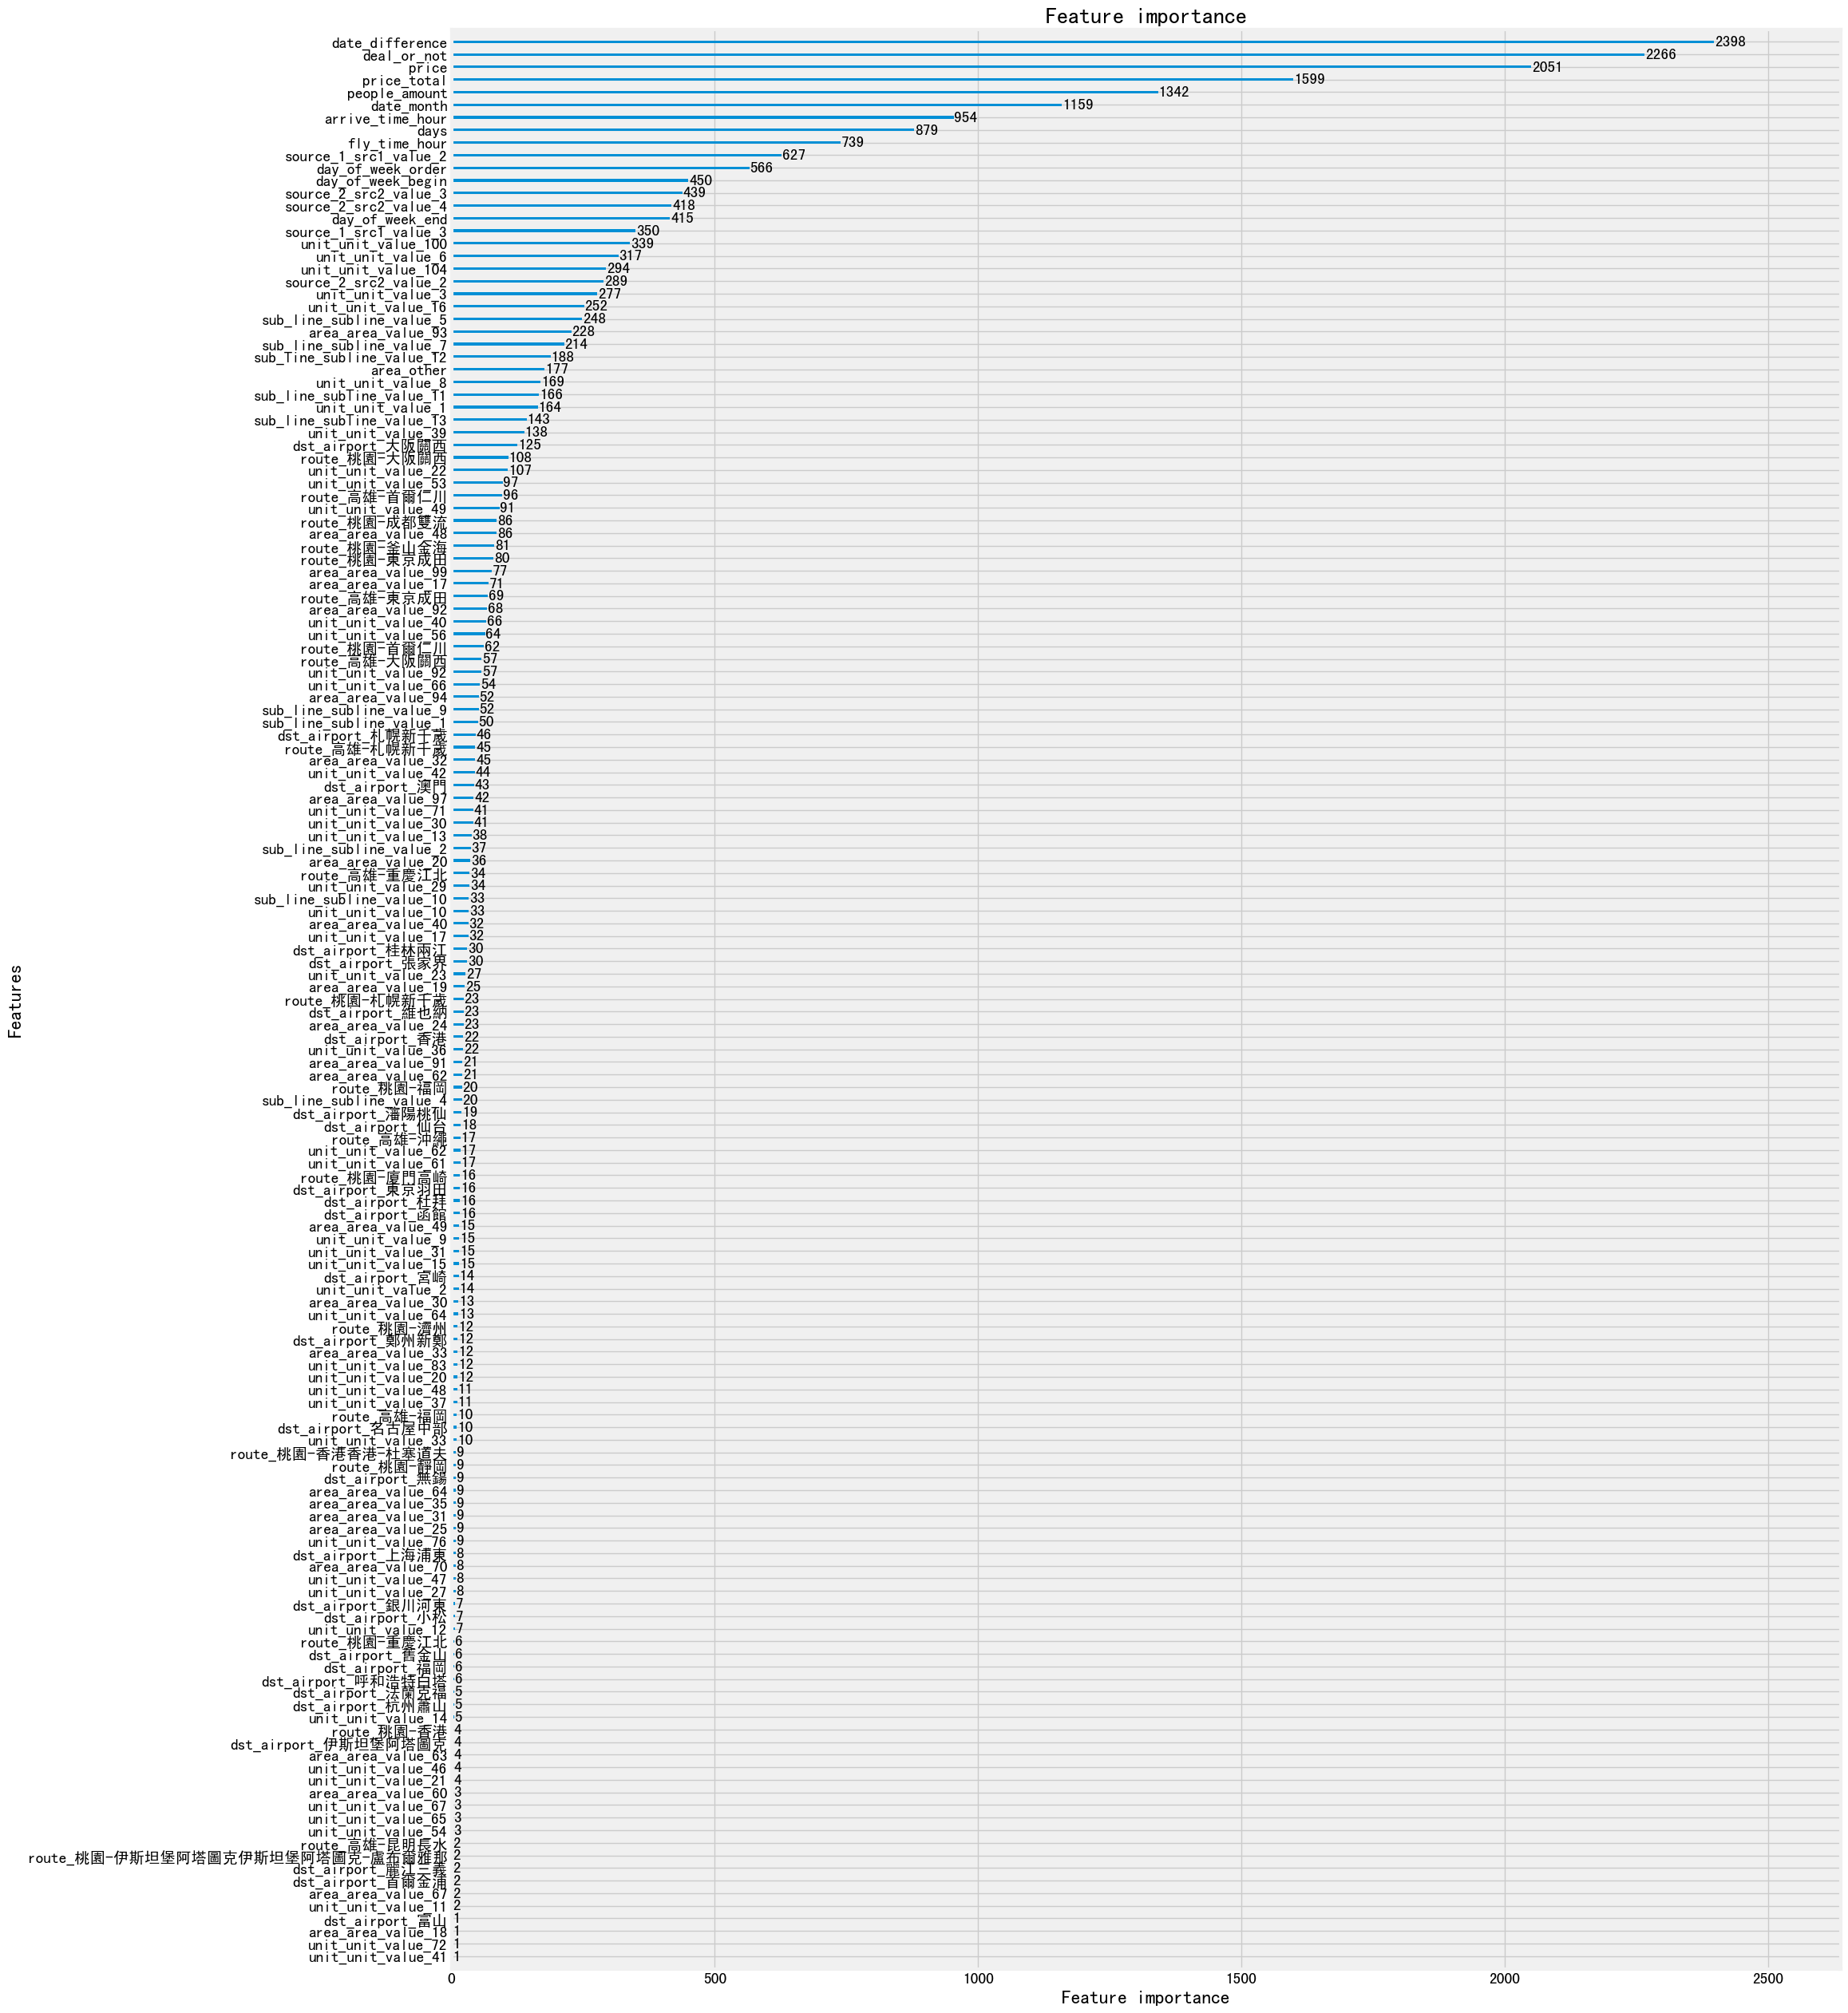

In [2622]:
lgb.plot_importance(model,figsize=(20,30))